### Importar bibliotecas

In [1]:
import warnings
warnings.filterwarnings('ignore')
import os

import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from matplotlib import pyplot as plt
from statsmodels.tools.eval_measures import mse
from statsmodels.tsa.arima_model import ARIMAResults

### Carregar dados

In [2]:
# Carregar dados do CPU
machine = 'm_103.csv'
workload = pd.read_csv(machine, 
             names = ['machine_id', 'time_stamp', 'cpu', 'mem', 'mem_gps', 
                      'mkpi', 'net_in', 'net_out', 'disk_io_percent'])
workload.time_stamp = pd.to_datetime(workload.time_stamp, unit='s')
workload.set_index('time_stamp', inplace=True)
workload = workload.resample('1min').interpolate()
workload

,machine_id,cpu,mem,mem_gps,mkpi,net_in,net_out,disk_io_percent
time_stamp,,,,,,,,
1970-01-01 00:00:00,m_103,8.0,85.0,NaN,NaN,33.78,24.41,1.0
1970-01-01 00:01:00,m_103,9.0,85.0,NaN,NaN,33.78,24.41,1.0
1970-01-01 00:02:00,m_103,7.0,84.0,NaN,NaN,33.78,24.41,1.0
1970-01-01 00:03:00,m_103,6.0,85.0,NaN,NaN,33.78,24.41,1.0
1970-01-01 00:04:00,m_103,8.0,85.0,NaN,NaN,33.78,24.41,1.0
...,...,...,...,...,...,...,...,...
1970-01-08 23:55:00,m_103,21.0,91.0,2.08,0.0,45.89,32.64,1.0
1970-01-08 23:56:00,m_103,16.0,90.0,2.05,0.0,45.89,32.64,3.0
1970-01-08 23:57:00,m_103,17.0,90.0,3.17,0.0,45.89,32.64,2.0


###  Separar treino e teste

In [3]:
# Separar conjunto de treino e de teste dos dadas de CPU
test_perc = 1/(len(workload)//60)
test_len = int(len(workload)*test_perc)
str_test_perc = f'{test_len/len(workload):0.2f}'
train_set = workload.cpu[:-test_len]
test_set = workload.cpu[-test_len:]

### Modelo ARIMA

In [4]:
# modelo ARIMA
order=(1,0,0)
model_train = ARIMA(train_set, order=order).fit()
model_test = ARIMA(test_set, order=order).fit(model_train.params)
model_test.params

const     19.108950
ar.L1      0.568507
sigma2    28.626981
dtype: float64

### Seleção dos melhores parâmetros
O método ARIMA(p,d,q) recebe 3 parâmetros que representam:
- p: componente autoregressivo
- d: diferença (usado quando a série não é estacionária)
- q: componente de média móvel

O script abaixo cria diversos modelos, com parâmetors distintos e apresenta ao final a melhor ordem (conjunto de parâmetros) do modelo que obteve o menor erro

In [5]:
# define alguns valores limites a serem testados 
# neste caso a diferença (d) será zero, pois a série é estacionária
max_p, max_d, max_q = 12, 0, 5

# cria uma lista com todas as combinações possíveis destes parâmetros, observando os limites definidos acima
orders = []
for p in range(max_p+1):
    for d in range(max_d+1):
        for q in range(max_q+1):
            orders.append((p,d,q))

# valida cada modelo
errors = []
for order in orders:
    model_name = f'/media/danilo/DADOS/SBRC2021/models/arima_{str_test_perc.replace(".","")}_{"".join(map(str, order))}_{machine.replace(".csv", "")}.pkl'
    if not os.path.isfile(model_name):
        # cria e salva um modelo caso não exista
        model_train = ARIMA(train_set, order=order).fit()
        model_test = ARIMA(test_set, order=order, enforce_stationarity=False).fit(model_train.params)
        model_test.save(model_name)
        print(f"Modelo salvo em: '{model_name}' ")
    else:
        # carrega um modelo salvo
        model_test = ARIMAResults.load(model_name)
        
    # guarda os erros de cada modelo em uma lista
    predict_set = model_test.predict().shift(-1)[:-1]
    error = mse(test_set[:-1], predict_set)
    errors.append(error)
    print(order, error, end = ' | ')

# identifica a melhor ordem (p,d,q) que apresentou o menor erro
best_order = None
for order, error in zip(orders, errors):
    best_error = min(errors)
    best_order = order if error == best_error else best_order
print(f'\n\nMelhor resultado:\n\tordem: {best_order}\n\terro: {best_error}')

(0, 0, 0) 42.52919428353873 | (0, 0, 1) 20.24126046607664 | (0, 0, 2) 18.02767219565106 | (0, 0, 3) 16.414037644227772 | (0, 0, 4) 12.219801232635076 | (0, 0, 5) 19.12134978061903 | (1, 0, 0) 7.936678513025616 | (1, 0, 1) 8.666177052669267 | (1, 0, 2) 12.058985425374084 | (1, 0, 3) 12.413687489328279 | (1, 0, 4) 12.945132144502269 | (1, 0, 5) 12.557180585464204 | (2, 0, 0) 10.115757742010373 | (2, 0, 1) 8.008907528082053 | (2, 0, 2) 8.857924016375014 | (2, 0, 3) 12.166733504706304 | (2, 0, 4) 12.422400776717136 | (2, 0, 5) 14.592719707319057 | (3, 0, 0) 10.129009428443903 | (3, 0, 1) 10.267648180787145 | (3, 0, 2) 9.53818718913041 | (3, 0, 3) 10.55334329027732 | (3, 0, 4) 12.51049881043015 | (3, 0, 5) 13.136414744636376 | (4, 0, 0) 10.647777253828982 | (4, 0, 1) 10.272698711136124 | (4, 0, 2) 10.963985746629374 | (4, 0, 3) 11.118300895295143 | (4, 0, 4) 12.204823849725008 | (4, 0, 5) 12.475221585546459 | (5, 0, 0) 10.706820764139225 | (5, 0, 1) 10.747736644985862 | (5, 0, 2) 11.8767211

### Execução do modelo com os melhores parâmetros

In [6]:
# modelo ARIMA
order=best_order
model_train = ARIMA(train_set, order=order).fit()
model_test = ARIMA(test_set, order=order).fit(model_train.params)
model_test.params

const     19.108950
ar.L1      0.568507
sigma2    28.626981
dtype: float64

### Comparar previsão x teste

Text(0, 0.5, '% cpu')

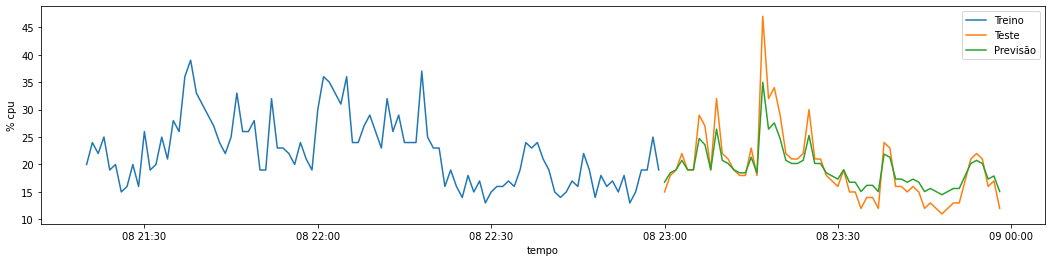

In [11]:
# compara a previsão com o conjunto de teste
predict_set = model_test.predict().shift(-1)[:-1]
plt.figure(figsize=(18,4))
plt.plot(train_set[-100:])
plt.plot(test_set[:-1])
plt.plot(predict_set)
plt.legend(['Treino', 'Teste', 'Previsão'])
plt.xlabel('tempo')
plt.ylabel('% cpu')

### Previsão de valores futuros

1970-01-09    15.635967
Freq: T, dtype: float64

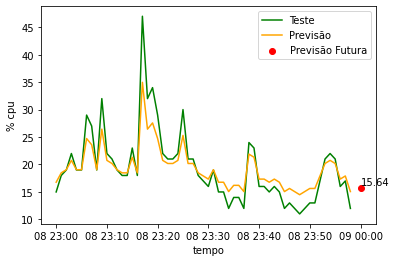

In [12]:
# Próximo passo
predict = model_test.forecast()
plt.figure(figsize=(6,4))
#plt.plot(train_set[-10:])
plt.plot(test_set[:-1], color='green')
plt.plot(predict_set, color='orange')
plt.scatter(predict.index, predict, color='red')
plt.text(predict.index, predict*1.035, f'{predict[0]:.2f}')
plt.legend(['Teste', 'Previsão', 'Previsão Futura'])
plt.xlabel('tempo')
plt.ylabel('% cpu')
predict

Text(0, 0.5, '% cpu')

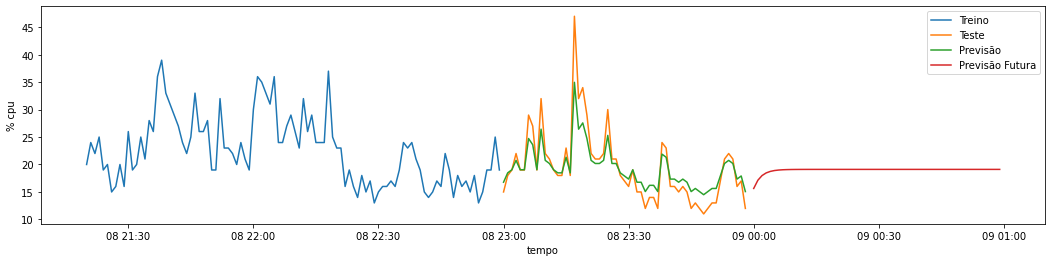

In [9]:
# Conjunto de passos futuros
predict = model_test.forecast(steps=60)
plt.figure(figsize=(18,4))
plt.plot(train_set[-100:])
plt.plot(test_set[:-1])
plt.plot(predict_set)
plt.plot(predict)
plt.legend(['Treino', 'Teste', 'Previsão', 'Previsão Futura'])
plt.xlabel('tempo')
plt.ylabel('% cpu')

### Validação do modelo
Na validação do modelo foi utilizada a técnica do erro quadrático médio, com o método 'mse' da biblioteca statsmodels.
Este método recebe como parâmetro o conjunto de teste e a previsão gerada pelo modelo. O resultado apresentado significa a taxa de erro, quanto menor melhor.

In [10]:
mse(test_set[:-1], predict_set)

7.936678513025616